In [2]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import seed
from random import gauss
import random
from collections import Counter

In [3]:
# funções auxiliares

from math import log10, floor

def round_it(x, sig):
    return round(x, sig - int(floor(log10(abs(x)))) - 1)


# Tempo de queda da esfera

Neste notebook usamos dados reais para entender como a aplicação vai funcionar. Os dados são de 5 relatórios da disciplina física experimental 1 dada na UFRJ pelo professor Marcelo M. Sant'Anna durante a pandemia de COVID-19 (ensino remoto).

As medidas foram feitas lançando-se uma moeda a partir do repouso de uma altura de 1.5 m e medindo-se o tempo de queda com um cronômetro de celular.

## Dados reais para o cálculo do desvio padrão

Baixamos os dados que organizamoso em um arquivo csv e usamos o método sample para embaralhar os dados dos cinco relatórios, que estavam em ordem no arquivo.

In [7]:
tempos_ordem = pd.read_csv('tempos.csv')
tempos = tempos_ordem.sample(frac=1).reset_index().drop(columns=['index'])

Olhando o arquivo para ver se está em ordem.

In [9]:
tempos

,tempos
0,0.57
1,0.63
2,0.39
3,0.55
4,0.35
...,...
595,0.50
596,0.35
597,0.50
598,0.57


Vamos fazer um histograma para olhar a distribuição dos dados.

<Axes: ylabel='Count'>

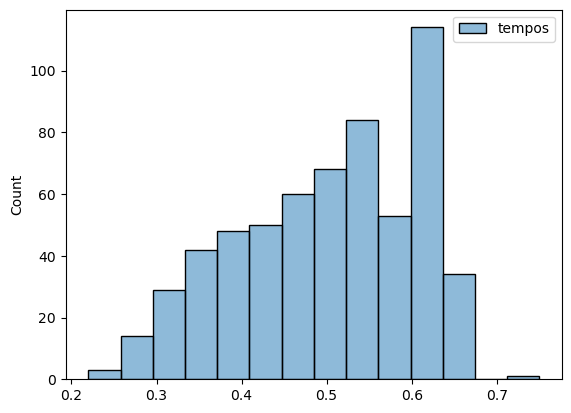

In [12]:
sns.histplot(tempos)

Calculando as estatísticas do conjunto de dados:

In [14]:
tempos.describe()

,tempos
count,600.000000
mean,0.503267
std,0.104925
min,0.220000
25%,0.430000
50%,0.520000
75%,0.590000
max,0.750000


De todo os valores da estatística, o desvio padrão é o mais interessante pois ele mede a largura da distribuição e não é algo intuitivo ou simples de supor. Vamos usar esse desvio padrão como referência para criar o *default* da aplicação.

In [15]:
desvio_padrao = tempos.std().item()
desvio_padrao

0.10492542333959796

## Simulação

Criamos uma função que simula os dados a partir de uma gaussiana centrada no valor esperado para o tempo de queda da bolinha. O desvio padrão deve ser fornecido. Usaremos o desvio que encontramos da amostra real de dados como padrão.

Para formar o conjunto de dados simulamos N_medidas medidas.

A ideia é dividir as medidas em N_conj subconjuntos para poder olhar a estatística de grupamentos menores de dados, entendendo o efeito de fazer mais medidas para o resultado estatístico. A divisão é feita da seguinte forma: o primeiro subconjunto contém 10% dos dados, o segundo, contem 20%, o terceiro, 30% e assim sucessivamente. O décimo subconjunto contém todos os dados. 

Na mesma função, vamos calcular média e desvio padrão dos subconjuntos simulados e armazenar para posterior análise. Junto com a média e o desvio padrão, vamos calcular e armazenar a incerteza do valor médio, dada pelo desvio padrão dividido pela raiz do número de medidas do subconjunto. Vamos usar essa incerteza da média dos subconjuntos para comparar com a precisão do cronômetro do celular usado nas medidas. Esperamos que, depois de um certo número de medidas, possamor superar a resolução do cronômetro.

In [50]:
def medidas(N_medidas, h, desvio_padrao):
    
    t = (2*h/9.787899) **(0.5) # cálculo do valor esperado para a altura dada
    
    N_conj = 10 # número de subconjuntos
    
    medidas = pd.Series([gauss(t,desvio_padrao) for i in range(N_medidas)])
        
    estatistica = pd.DataFrame(columns=['media', 'desvio', 'incerteza'])
    for i in range(1, N_conj+1):
        medidas_frac = medidas.iloc[:int(i*N_medidas/N_conj)]
        estatistica_frac = pd.DataFrame({
            'media':[medidas_frac.mean()],
            'desvio':[medidas_frac.std()],
            'incerteza':[medidas_frac.std()/(medidas_frac.size)**0.5],
        })
        estatistica = pd.concat([estatistica, estatistica_frac])
    
    return medidas, estatistica.reset_index()


Abaixo vamos definir uma função que calcula apenas as estatísticas dos dados, sem simulação. Essa função será usada para tratar os dados reais da mesma maneira que os dados simulados.

In [52]:
def estatistica(dados):
     
    N_conj = 10 # número de subconjuntos
    medidas = dados
    N_medidas = len(dados)
    
    estatistica = pd.DataFrame(columns=['media', 'desvio', 'incerteza'])
    for i in range(1, N_conj+1):
        medidas_frac = medidas.iloc[:int(i*N_medidas/N_conj)]
        estatistica_frac = pd.DataFrame({
            'media':[medidas_frac.mean()],
            'desvio':[medidas_frac.std()],
            'incerteza':[medidas_frac.std()/(medidas_frac.size)**0.5],
        })
        estatistica = pd.concat([estatistica, estatistica_frac])
    
    return estatistica.reset_index()


## Comparação entre simulação e conjunto real

Vamos definir o conjunto de medidas mreal e calcular a estatística de 10 subconjuntos dos dados.

In [53]:
mreal = tempos['tempos']
ereal = estatistica(tempos['tempos'])

Definindo o conjunto de teste simulado também dividido em 10 subconjuntos de 60 dados, totalizando 600 medidas. Usamos o desvio padrão idêntico ao dos dados reais. 

In [54]:
m1, e1 = medidas(600, 1.5, desvio_padrao)
m1

0      0.491083
1      0.398506
2      0.522113
3      0.628624
4      0.584434
         ...   
595    0.575981
596    0.441994
597    0.498640
598    0.378210
599    0.643672
Length: 600, dtype: float64

A função abaixo plota os dados na ordem em que são sorteados ou se apresentam no arquivo de dados real e compara com o valor esperado calculado a partir de h.

In [55]:
def plot_dados(m1,h):
    fig, ax = plt.subplots()
        
    m1.plot(
            ax=ax,
            color='orange',
            marker='o',
            ls=':',
        )
        
    t = (2*h/9.787899) **(0.5)
        
    ax.axhline(
            t,
            color='blue',
            ls='--',
            label='valor de referência',
        )
    ax.set_title('Conjunto de dados')
    #ax.set_xlabel('dados')
    ax.set_ylabel('tempo de queda (s)')
    ax.legend(ncols=1)
    
    ax.text(
            0.5,
            0.5,
            "MP-resuldados",
            transform=ax.transAxes,
            fontsize=40,
            color="gray",
            alpha=0.1,
            ha="center",
            va="center",
            rotation=45,
            )
    return fig, ax

Para os dados simulados, temos:

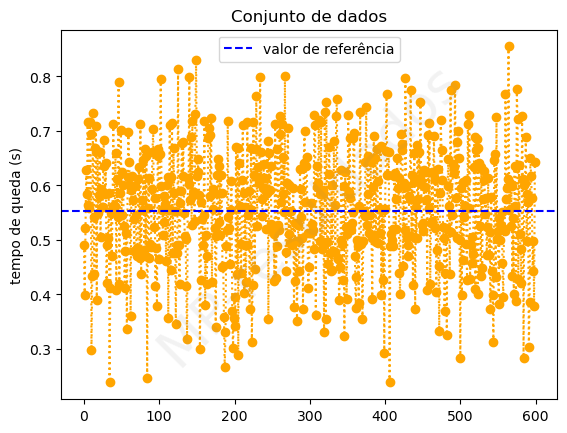

In [57]:
# salvando para o READ.ME
figura0a = plot_dados(m1, 1.5)[0]
#figura0a.savefig('dados_simulados.png')

Para os dados reais, temos:

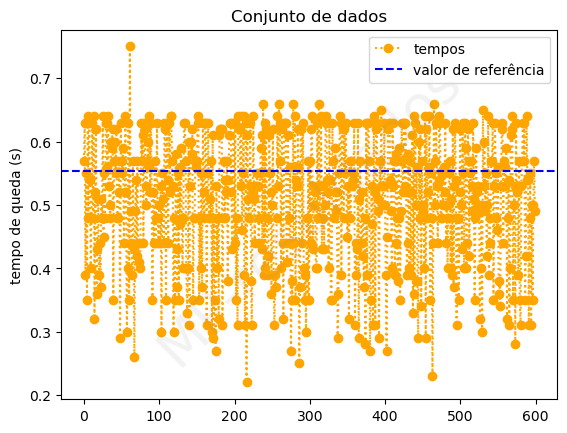

In [59]:
# salvando para o READ.ME
figura0b = plot_dados(mreal, 1.5)[0]
#figura0b.savefig('dados_reais.png') 

Já podemos notar a presença de erros sistemáticos no conjunto real de dados. A distribuição não está perfeitamente distribuída em torno do valor esperado como vemos nos dado simulados.

### Comparação das médias dos dados simulados e reais

A função abaixo faz o gráfico dos valores médios considerando os 10 subconjuntos de 60 dados. Lembrando que o primeiro subconjunto contém respectivamente 10% dos dados, o segundo, contem 20%, o terceiro, 30% e assim sucessivamente. O décimo subconjunto contém todos os dados. 

In [61]:
def plot_medias(estatistica, h):
    fig, ax = plt.subplots()

    t = (2*h/9.787899) **(0.5)

        # valor de referência
    ax.axhline(t,
        color='blue',
        linestyle='dashed',
        label='valor de referência'
        )
            
        # média e incerteza
    ax.errorbar(
            10*(1+estatistica.index),
            estatistica['media'],
            yerr = estatistica['incerteza'],
            color='orange',
            marker='.',
            linestyle='none',
            label='valores médios'
        )
    
    ax.set_title('Evolução do valor médio')
    ax.set_xlabel('% dos dados')
    ax.set_ylabel('tempo de queda (s)')
    ax.legend(ncols=1)
    
    ax.text(
            0.5,
            0.5,
            "MP-resuldados",
            transform=ax.transAxes,
            fontsize=40,
            color="gray",
            alpha=0.1,
            ha="center",
            va="center",
            rotation=45,
            )
    
    return fig, ax

Para os dados simulado, temos:

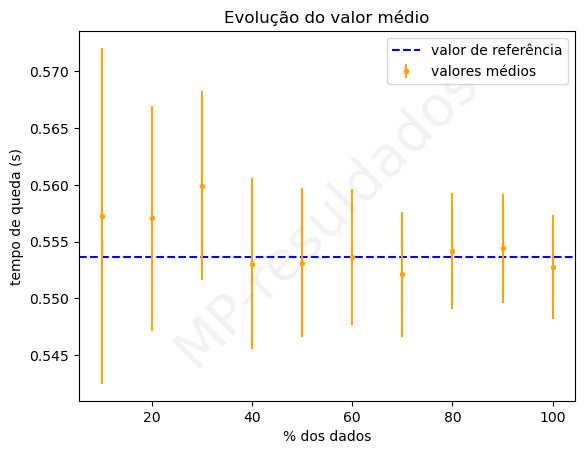

In [64]:
# salvando para o READ.ME
figura1a = plot_medias(e1, 1.5)[0]
#figura1a.savefig('medias_simulado.png') 

Para os dados reais, temos:

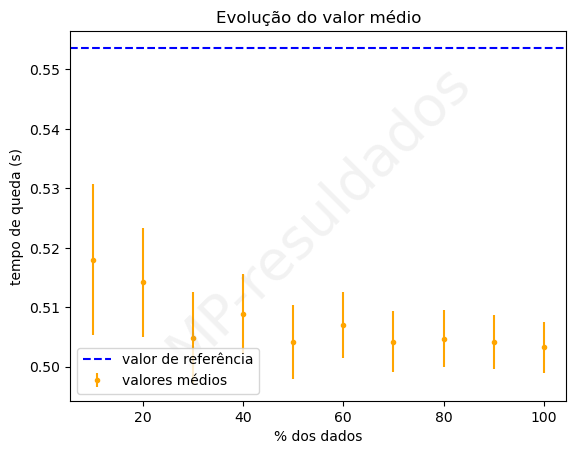

In [65]:
# salvando para o READ.ME
figura1b = plot_medias(ereal, 1.5)[0]
#figura1b.savefig('medias_real.png')

Vemos que rapidamente os dados convergem para um valor. No caso dos dados simulados, para o valor esperado. No caso dos dados reais, para um valor abaixo, evidenciando a presença de erros sistemáticos. 

## Histogramas

A função abaixo cria histogramas dos dados para os seguintes subconjuntos de medidas: 25% dos dados, 50% dos dados, 75% e 100% dos dados.

In [66]:
def plot_hist(m1):
    fig, axs_arr = plt.subplots(2, 2, sharex=True, sharey=True)

    axs = [ax for axs in axs_arr for ax in axs]
    fracs = [.25, .50, .75, 1]
    colors = ['orange', 'r', 'g', 'b']

    for ax, frac, color in zip(axs, fracs, colors):
    
        a = m1[:int(frac*len(m1))]
    
        sns.histplot(a, alpha=0.4, ax=ax, label=f'{int(100*frac)}%', color=color)

        ax.set_xlabel('tempo de queda (s)')
        ax.set_ylabel('contagem')
        ax.legend(loc='upper right')
    
    fig.text(
            0.5,
            0.5,
            "MP-resuldados",
            fontsize=50,
            color="gray",
            alpha=0.1,
            ha="center",
            va="center",
            rotation=45,
    )
    
    return fig, ax    

Para os dados simulados, temos:

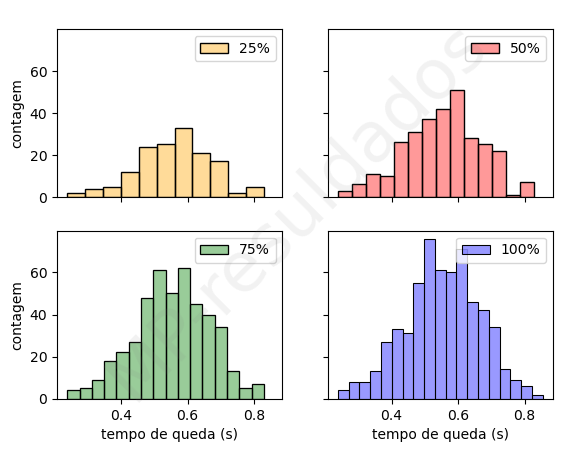

In [67]:
# salvando para o READ.ME
figura2a = plot_hist(m1)[0]
#figura2a.savefig('hist_simulado.png') 

In [ ]:
Para os dados reais, temos:

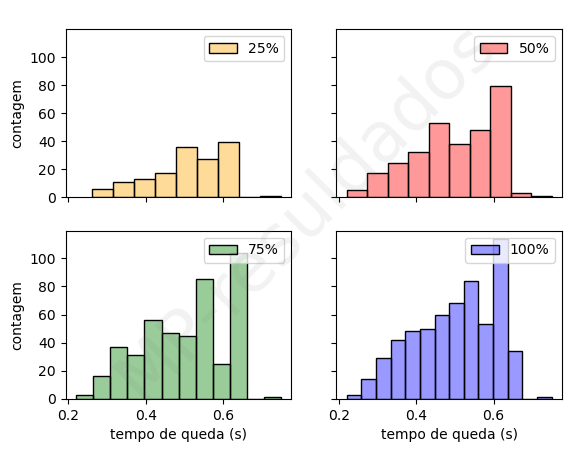

In [68]:
# salvando para o READ.ME
figura2b = plot_hist(mreal)[0]
#figura2b.savefig('hist_real.png') 

Vemos que os histogramas simulados são mais simétricos que os histogramas reais, evidenciando a presença de erros sistemático nos dados reais mais uma vez.

## Comparação do desvio padrão com a resolução do cronômetro

A função abaixo faz o plot da incerteza do valor médio dos 10 subconjuntos de 60 dados. Lembrando que o primeiro subconjunto contém respectivamente 10% dos dados, o segundo, contem 20%, o terceiro, 30% e assim sucessivamente. O décimo subconjunto contém todos os dados. 

In [69]:
def plot_desvio(estatistica):
    fig, ax = plt.subplots()

        # resolução do cronômetro
    ax.axhline(0.01,
            color='green',
            linestyle='dotted',
            label='resolução do cronômetro'
            )

        # desvio para diversos conjuntos com quantidade de medidas diferentes
    ax.plot(
            10*(1+estatistica.index),
            estatistica['incerteza'],
            color='orange',
            marker='o',
            linestyle='none',
            label='Incerteza do valor médio'
            )


    ax.set_title('Evolução da incerteza do valor médio')
    ax.set_xlabel('% dos dados')
    ax.set_ylabel('tempo de queda (s)')
    ax.legend(ncols=1)
    
    ax.text(
            0.5,
            0.5,
            "MP-resuldados",
            transform=ax.transAxes,
            fontsize=40,
            color="gray",
            alpha=0.1,
            ha="center",
            va="center",
            rotation=45,
            )
    
    
    return fig, ax

In [ ]:
Para os dados simulados, temos:

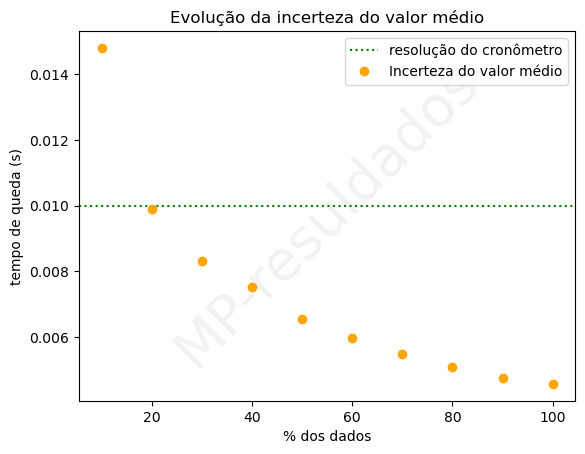

In [70]:
figura3a = plot_desvio(e1)[0]
figura3a.savefig('desvio_simulado.png') 

In [ ]:
Para os dados reais, temos:

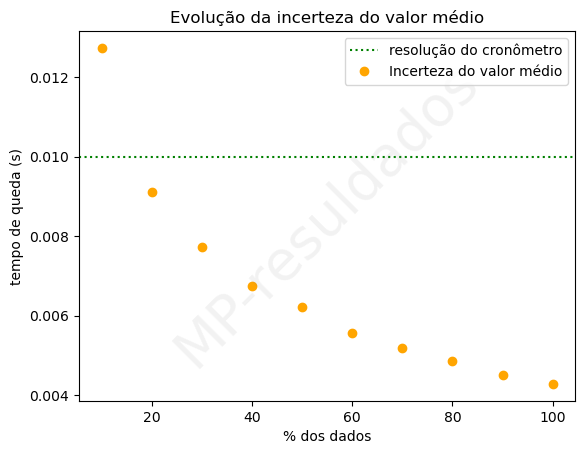

In [71]:
figura3b = plot_desvio(ereal)[0]
#figura3b.savefig('desvio_real.png') 

Em ambos os casos a incerteza das medidas fica rapidamente menor que a resolução de um cronõmetro de celular.

Mais discussões sobre erros sistemáticos, aleatórios e precisão das medidas no READ.ME.   ;)